In [6]:
import glob
import numpy as np
import copy
from shapely.geometry import LineString, Polygon, Point
import matplotlib.pyplot as plt
import os.path

# Utility Functions

def dist_2_points(x1, x2, y1, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def x_perc_width(waypoint, perc_width):
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    delta_x = outer_x - inner_x
    delta_y = outer_y - inner_y
    return [
        center_x, center_y,
        inner_x + delta_x * (1 - perc_width) / 2,
        inner_y + delta_y * (1 - perc_width) / 2,
        outer_x - delta_x * (1 - perc_width) / 2,
        outer_y - delta_y * (1 - perc_width) / 2
    ]

# Main Functions

def load_track(track_name):
    return np.load(f"./deepracer-race-data/raw_data/tracks/npy/{track_name}.npy")

def reduce_track_width(waypoints, perc_width=0.8):
    return np.array([x_perc_width(waypoint, perc_width) for waypoint in waypoints])

def menger_curvature(pt1, pt2, pt3, atol=1e-3, epsilon=1e-9):
    vec21 = np.array([pt1[0] - pt2[0], pt1[1] - pt2[1]])
    vec23 = np.array([pt3[0] - pt2[0], pt3[1] - pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)
    
    if norm21 < epsilon or norm23 < epsilon:
        return 0.0

    dot_product = np.dot(vec21, vec23)
    denominator = norm21 * norm23
    
    # Clamp the value to be in the range [-1, 1] to avoid invalid inputs to arccos
    theta_input = np.clip(dot_product / denominator, -1.0, 1.0)
    
    theta = np.arccos(theta_input)
    
    if np.isclose(theta - np.pi, 0.0, atol=atol):
        theta = 0.0
    
    dist13 = np.linalg.norm(vec21 - vec23)
    
    return 2 * np.sin(theta) / dist13


def improve_race_line(old_line, inner_border, outer_border, xi_iterations=8):
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    n = len(new_line)

    for i in range(n):
        xi = new_line[i]
        prevprev, prev, nexxt, nexxtnexxt = (i - 2) % n, (i - 1) % n, (i + 1) % n, (i + 2) % n
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        target_ci = (menger_curvature(new_line[prevprev], new_line[prev], xi) + 
                     menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])) / 2

        xi_bound1 = xi
        xi_bound2 = np.mean([new_line[nexxt], new_line[prev]], axis=0)
        p_xi = xi

        for _ in range(xi_iterations):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])

            if np.isclose(p_ci, target_ci):
                break

            if p_ci < target_ci:
                xi_bound2 = p_xi
                new_p_xi = np.mean([xi_bound1, p_xi], axis=0)
            else:
                xi_bound1 = p_xi
                new_p_xi = np.mean([xi_bound2, p_xi], axis=0)

            if (Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border)):
                continue

            p_xi = new_p_xi

        new_line[i] = p_xi

    return new_line


def plot_track(race_line, inner_border, outer_border):
    fig, ax = plt.subplots()
    ax.plot(*race_line.T, label='Race Line', color='r')
    ax.plot(*inner_border.T, label='Inner Border', color='g')
    ax.plot(*outer_border.T, label='Outer Border', color='b')
    ax.legend()
    plt.show()


['arctic_pro_cw', 'Monaco_building', 'jyllandsringen_open_ccw', '2022_march_open', '2022_march_pro_cw', 'morgan_pro', 'thunder_hill_open', '2022_august_open', '2022_march_pro', 'jyllandsringen_open_cw', 'H_track', 'thunder_hill_pro_cw', '2022_october_pro_ccw', 'dubai_open', '2022_march_open_cw', 'arctic_pro_ccw', 'Oval_track', '2022_october_open_cw', 'Bowtie_track', 'Spain_track', 'Vegas_track', 'arctic_open_cw', 'Singapore_f1', '2022_april_pro_ccw', '2022_june_pro_cw', 'morgan_open', 'New_York_Track', 'dubai_open_cw', '2022_june_open_ccw', '2022_september_open_ccw', '2022_march_open_ccw', 'jyllandsringen_pro_ccw', 'penbay_pro_cw', '2022_july_pro_cw', '2022_april_open_cw', 'Belille', '2022_may_pro_cw', '2022_summit_speedway_cw', '2022_october_pro', 'red_star_pro_ccw', 'Albert', 'AmericasGeneratedInclStart', 'red_star_pro', 'dubai_pro', 'caecer_loop', 'penbay_open_cw', 'reInvent2019_track_cw', 'FS_June2020', 'Singapore', 'Singapore_building', 'dubai_open_ccw', '2022_summit_speedway', '2

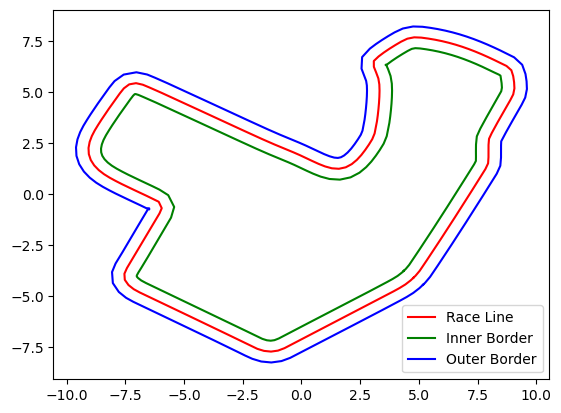

In [12]:

# Main Program

# Load the track
available_track_files = glob.glob("./deepracer-race-data/raw_data/tracks/npy/*.npy")
available_track_names = [os.path.basename(x).split('.npy')[0] for x in available_track_files]
print(available_track_names)
TRACK_NAME = available_track_names[1]  # Replace with the track you want to use
TRACK_NAME = [x for x in available_track_names if x == "2022_september_pro_ccw"][0]
waypoints = load_track(TRACK_NAME)

# Reduce track width
PERC_WIDTH = 0.8
reduced_waypoints = reduce_track_width(waypoints, PERC_WIDTH)

#Get border
inner_border = waypoints[:, 2:4]
outer_border = waypoints[:, 4:6]
center_line = waypoints[:, 0:2]

plot_track(center_line,inner_border,outer_border)



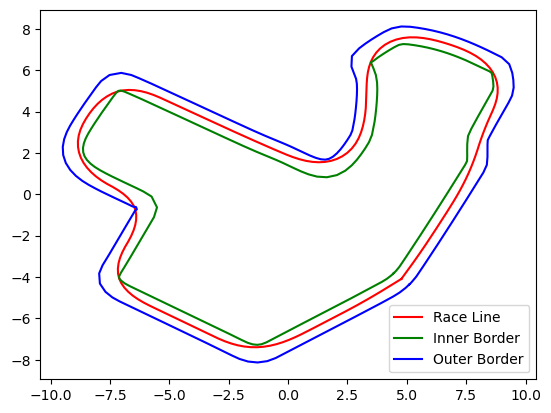

In [13]:
# Improve the race line
LINE_ITERATIONS = 100
XI_ITERATIONS = 8
race_line = np.array(reduced_waypoints)[:, 0:2]  # Initialize with center line
for _ in range(LINE_ITERATIONS):
    race_line = improve_race_line(
        race_line,
        reduced_waypoints[:, 2:4],
        reduced_waypoints[:, 4:6],
        XI_ITERATIONS
    )

# Plot the track
plot_track(race_line, reduced_waypoints[:, 2:4], reduced_waypoints[:, 4:6])

In [14]:
# Assume `improved_line` is the output from `improve_race_line`
# Assume `inner_border` and `outer_border` are the inner and outer track boundaries
# All are NumPy arrays of shape (N, 2)

racing_track = []

for i in range(len(race_line)):
    waypoint = []
    waypoint.extend(race_line[i])  # x, y of racing line
    waypoint.extend(inner_border[i])  # x, y of inner border
    waypoint.extend(outer_border[i])  # x, y of outer border
    # Optionally, add any other information you want to store for each waypoint
    racing_track.append(waypoint)

# Convert to NumPy array for easier manipulation later, if needed
racing_track = np.array(racing_track)

In [15]:
def save_result(array):
    np.save('./output/optimized_waypoints',array)
    print("save successfully")
save_result(race_line)
display(race_line)

save successfully


array([[ 4.76983251, -4.09053386],
       [ 4.8912562 , -3.90066133],
       [ 5.01365553, -3.70836878],
       [ 5.13781819, -3.51168709],
       [ 5.26438495, -3.30898669],
       [ 5.39387536, -3.09890433],
       [ 5.52666214, -2.88039606],
       [ 5.66290725, -2.65288908],
       [ 5.80250824, -2.41641704],
       [ 5.9451244 , -2.17155263],
       [ 6.0901623 , -1.91945178],
       [ 6.23679316, -1.66184451],
       [ 6.38407394, -1.40079039],
       [ 6.53117152, -1.13819479],
       [ 6.67774822, -0.87512328],
       [ 6.82298559, -0.61149822],
       [ 6.96518915, -0.34687074],
       [ 7.10287005, -0.08086031],
       [ 7.23486376,  0.18682987],
       [ 7.36034638,  0.45640552],
       [ 7.47877086,  0.72799803],
       [ 7.58987165,  1.00166238],
       [ 7.69367465,  1.27737487],
       [ 7.79035845,  1.55507532],
       [ 7.88036131,  1.83466183],
       [ 7.96421714,  2.11617999],
       [ 8.04274282,  2.40034647],
       [ 8.12661932,  2.68351128],
       [ 8.21609434,